In [5]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

model_name = "bert-base-uncased"
dataset_path = "data/yelp_review_polarity_csv"

df_train = pd.read_csv(f"{dataset_path}/train.csv", header=None, names=["label", "text"])
df_test = pd.read_csv(f"{dataset_path}/test.csv", header=None, names=["label", "text"])
df_train, df_val = train_test_split(df_train, test_size=0.3)

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from torch.utils.data import DataLoader
from dataset import TextDataset
from transformers import DataCollatorWithPadding
import torch
import torch.nn as nn

collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(TextDataset(df_train, tokenizer), batch_size=128, collate_fn=collator)
val_loader = DataLoader(TextDataset(df_val, tokenizer), batch_size=128, collate_fn=collator)
test_loader = DataLoader(TextDataset(df_test, tokenizer), batch_size=128, collate_fn=collator)

batch = next(iter(train_loader))
bert.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
)

out = bert(batch["input_ids"], attention_mask=batch["attention_mask"])
sum(p.numel() for p in bert.parameters()), sum(p.numel() for p in bert.classifier.parameters()), out.logits.shape

(109745153, 262913, torch.Size([128, 1]))

In [4]:
for param in bert.parameters():
    param.requires_grad = False

for param in bert.classifier.parameters():
    param.requires_grad = True

In [5]:
def choose_device() -> str:
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

In [6]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

epochs = 3
device = torch.device(choose_device())
print(f"Training on device: {device}")

bert.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(bert.classifier.parameters(), lr=5*1e-4)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs + 1):
    bert.train()
    total_loss, correct, total = 0.0, 0, 0

    progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{epochs}")

    for i, batch in progress:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        out = bert(batch["input_ids"], attention_mask=batch["attention_mask"]).logits

        loss = criterion(out.view(-1), batch["labels"].view(-1).float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.sigmoid(out).view(-1)
        predicted_labels = (preds >= 0.5).long()

        correct += (predicted_labels == batch["labels"].view(-1)).sum().item()
        total += batch["labels"].numel()

        avg_loss = total_loss / (i + 1)
        acc = correct / total

        progress.set_postfix({"loss": f"{avg_loss:.4f}", "acc": f"{acc:.4f}"})

    train_losses.append(avg_loss)
    train_accs.append(acc)

    print(f"Epoch {epoch} TRAIN | Loss: {avg_loss:.4f} | Acc: {acc:.4f}")

    bert.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            out = bert(batch["input_ids"], attention_mask=batch["attention_mask"]).logits
            loss = criterion(out.view(-1), batch["labels"].view(-1).float())

            val_loss += loss.item()

            preds = torch.sigmoid(out).view(-1)
            predicted_labels = (preds >= 0.5).long()

            val_correct += (predicted_labels == batch["labels"].view(-1)).sum().item()
            val_total += batch["labels"].numel()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch} VAL   | Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

# Save the model
torch.save(bert.state_dict(), "bert.pt")

Training on device: cuda


Epoch 1/3: 100%|██████████| 3063/3063 [29:50<00:00,  1.71it/s, loss=0.3739, acc=0.8321]


Epoch 1 TRAIN | Loss: 0.3739 | Acc: 0.8321
Epoch 1 VAL   | Loss: 0.2835 | Acc: 0.8843


Epoch 2/3: 100%|██████████| 3063/3063 [29:59<00:00,  1.70it/s, loss=0.3503, acc=0.8445]


Epoch 2 TRAIN | Loss: 0.3503 | Acc: 0.8445
Epoch 2 VAL   | Loss: 0.3761 | Acc: 0.8163


Epoch 3/3: 100%|██████████| 3063/3063 [29:58<00:00,  1.70it/s, loss=0.3465, acc=0.8464]


Epoch 3 TRAIN | Loss: 0.3465 | Acc: 0.8464
Epoch 3 VAL   | Loss: 0.2806 | Acc: 0.8856


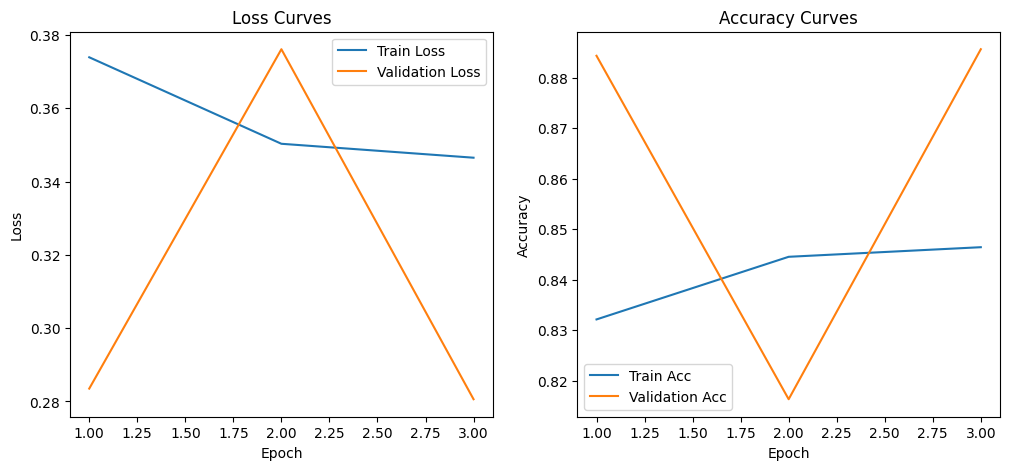

In [1]:
import matplotlib.pyplot as plt

epochs_range = [1, 2, 3]
train_losses = [0.3739, 0.3503, 0.3465]
val_losses = [0.2835, 0.3761, 0.2806]

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()


train_accs = [0.8321, 0.8445, 0.8464]
val_accs = [0.8843, 0.8163, 0.8856]

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.show()

In [7]:
progress = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Test evaluation")
bert.eval()

pred_labels = []
probas = []
real_labels = []

correct = 0
total = 0

with torch.inference_mode():
    for i, batch in progress:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = bert(batch["input_ids"], attention_mask=batch["attention_mask"]).logits

        preds = torch.sigmoid(out).view(-1)  # convert logits to probabilities
        predicted_labels = (preds >= 0.5).long()

        probas.append(preds)
        pred_labels.append(predicted_labels)
        real_labels.append(batch["labels"].view(-1))

        correct += (predicted_labels == batch["labels"].view(-1)).sum().item()
        total += batch["labels"].numel()
        acc = correct / total

        progress.set_postfix({"acc": f"{acc:.4f}"})

Test evaluation: 100%|██████████| 297/297 [02:47<00:00,  1.77it/s, acc=0.8881]


In [8]:
probas = torch.concatenate(probas)
real_labels = torch.concatenate(real_labels)

In [9]:
probas, real_labels = probas.to("cpu"), real_labels.to("cpu")

In [10]:
from sklearn.metrics import accuracy_score, f1_score

preds = (probas > 0.5).long()
acc = accuracy_score(real_labels, preds)
f1_macro = f1_score(real_labels, preds, average="macro")
f1_weighted = f1_score(real_labels, preds, average="weighted")

print("Accuracy:", acc)
print("F1 macro:", f1_macro)
print("F1 weighted:", f1_weighted)

Accuracy: 0.8881315789473684
F1 macro: 0.8880828400317666
F1 weighted: 0.8880828400317667
